In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 # Faster R-CNN + ResNet

In [1]:
!pip install torch torchvision pycocotools tqdm pillow --quiet

import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

# Caminhos e Classes (Adaptado para /kaggle/input/)

In [2]:
# SUBSTITUA 'robocup-coco-dataset' pelo nome do seu dataset no Kaggle
base_dir = "/kaggle/input/robocup-2-0" 

# Caminhos de Treinamento
# A estrutura de pastas 'robocup_coco' deve ser a raiz do seu upload.
train_dir = os.path.join(base_dir, "robocup_coco", "train", "Imagens")
train_ann = os.path.join(base_dir, "robocup_coco", "train", "_annotations.coco.json")

# Caminhos de Validação
val_dir = os.path.join(base_dir, "robocup_coco", "valid", "Imagens")
val_ann = os.path.join(base_dir, "robocup_coco", "valid", "_annotations.coco.json")

# Diretório de output no Kaggle (para salvar checkpoints)
output_dir = "/kaggle/outputs/robocup_output"
os.makedirs(output_dir, exist_ok=True)

# =======================
# DEFINIÇÃO DAS CLASSES
# =======================
CLASSES = [
    "AllenKey", "Axis2", "Bearing2", "Drill", "F20_20_B", "F20_20_G",
    "Housing", "M20", "M20_100", "M30", "Motor2", "S40_40_B", "S40_40_G",
    "Screwdriver", "Spacer", "Wrench", "container_box_blue", "container_box_red"
]
NUM_CLASSES = len(CLASSES) + 1  # +1 para background

# TRANSFORMAÇÕES

In [3]:
class Compose(object):
    """Compõe múltiplas transformações."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target_list):
        # target_list é a lista de dicts COCO
        for t in self.transforms:
            image, target_list = t(image, target_list)
        return image, target_list


class ToTensor(object):
    """Converte a imagem (PIL Image) para Tensor e mantém o target_list inalterado."""
    def __call__(self, image, target_list):
        if isinstance(image, Image.Image):
            image = F.to_tensor(image)
        # Retorna a lista de targets COCO inalterada
        return image, target_list


class RandomHorizontalFlip(object):
    """Inverte a imagem e ajusta as caixas delimitadoras COCO ([x, y, w, h])."""
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target_list):
        if np.random.rand() < self.flip_prob:
            # 1. Flip a imagem
            image = F.hflip(image)

            # 2. Obtém a largura da imagem
            if isinstance(image, torch.Tensor):
                # Se ToTensor foi aplicado antes
                width = image.shape[-1]
            else:  # Caso seja PIL Image
                width = image.width

            # 3. Ajusta as caixas delimitadoras (formato COCO: [x_min, y_min, w, h])
            # A inversão horizontal afeta apenas o x_min.
            # Novo x_min = width - (x_min_antigo + w)
            for obj in target_list:
                bbox = obj["bbox"]  # [x_min, y_min, w, h]
                x_min_old = bbox[0]
                w = bbox[2]

                # Calcula o novo x_min
                new_x_min = width - (x_min_old + w)

                # Atualiza o x_min na anotação COCO
                bbox[0] = new_x_min

        return image, target_list


def get_transform(train):
    """Define a composição de transformações para treinamento ou validação."""
    transforms_list = [ToTensor()]
    if train:
        # A RandomHorizontalFlip DEVE ser aplicada antes da conversão final para [x_min, y_min, x_max, y_max]
        transforms_list.append(RandomHorizontalFlip(0.5))
    return Compose(transforms_list)


# =======================
# DATASET COCO
# =======================

class CocoDataset(CocoDetection):
    """
    Dataset wrapper que aplica transformações e converte targets COCO
    (lista de dicts [x, y, w, h]) para o formato de Tensor do modelo
    (dict com 'boxes' [x_min, y_min, x_max, y_max]).
    """
    def __init__(self, img_folder, ann_file, transforms=None):
        # NÃO passe 'transforms' para o super().__init__ para controlar o fluxo
        super().__init__(img_folder, ann_file)
        self.transforms = transforms
        # Usamos self.ids para obter o COCO image_id real
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        # 1. Obter o ID real da imagem COCO
        # Usamos o 'idx' (índice da iteração) para buscar o 'image_id' real no mapeamento do dataset.
        img_id = self.ids[idx]

        # 2. Busca a imagem e anotações. A CocoDetection base deve ser chamada com o ÍNDICE DE ITERAÇÃO.
        # A correção é usar 'idx' aqui, em vez de 'img_id'.
        # A base CocoDetection usa 'idx' para buscar o ID da imagem e as anotações.
        img, target_list = super().__getitem__(idx) # ✅ CORREÇÃO: Passar 'idx' (índice), não 'img_id'


        # 3. Aplica as transformações (que modificam a imagem PIL/Tensor e a target_list COCO)
        if self.transforms:
            img, target_list = self.transforms(img, target_list)

        # 4. Converte a target_list (JÁ TRANSFORMADA) para o formato de Tensores do Modelo
        boxes, labels = [], []
        for obj in target_list:
            x_min, y_min, w, h = obj["bbox"]
            # Converte de [x, y, w, h] (COCO) para [x_min, y_min, x_max, y_max] (PyTorch)
            boxes.append([x_min, y_min, x_min + w, y_min + h])
            labels.append(obj["category_id"])

        # Lidar com o caso de imagens sem caixas delimitadoras
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        # Cria o dicionário final para o modelo
        target = {
            "boxes": boxes,
            "labels": labels,
            # Mantemos o image_id real (buscado no passo 1) no target
            "image_id": torch.tensor([img_id])
        }

        # Opcional: Adicionar área e is_crowd, se necessário pelo modelo
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        is_crowd = torch.zeros((len(labels),), dtype=torch.uint8)
        target["area"] = area
        target["iscrowd"] = is_crowd

        return img, target


def collate_fn(batch):
    """
    Função de colagem customizada para lidar com targets de tamanhos variáveis.
    Requerida por DataLoaders em tarefas de Detecção de Objetos.
    """
    # Descompacta o batch: (img1, target1), (img2, target2), ...
    return tuple(zip(*batch))

# DATALOADERS, MODELO E SETUP (Otimizado)

In [4]:
# =======================
# DATALOADERS (Otimizados)
# =======================
train_dataset = CocoDataset(train_dir, train_ann, transforms=get_transform(True))
val_dataset = CocoDataset(val_dir, val_ann, transforms=get_transform(False))

# Otimização de Velocidade: Aumente batch_size e ajuste num_workers
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,  
                          num_workers=4, collate_fn=collate_fn)      
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False,
                        num_workers=2, collate_fn=collate_fn)      


# =======================
# MODELO
# =======================
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# =======================
# OTIMIZADOR E SCHEDULER
# =======================
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

loading annotations into memory...
Done (t=1.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 139MB/s]  


# LOOP DE TREINAMENTO

In [ ]:
# 1° - CONFIGURAÇÃO DO MANTEDOR DE TELA (SILENCIOSO)
import threading
import time
import os
import json  
import zipfile 
import shutil 

def keep_awake():
    while True:
        time.sleep(60)  # Apenas espera em silêncio

awake_thread = threading.Thread(target=keep_awake, daemon=True)
awake_thread.start()

# 2° - SEU CÓDIGO DE TREINAMENTO COM VERIFICAÇÕES
NUM_EPOCHS = 30
output_dir = "/kaggle/working/robocup_output"

# Criar diretório
os.makedirs(output_dir, exist_ok=True)

# Verificar espaço livre
import shutil
total, used, free = shutil.disk_usage("/kaggle/working/")
print(f"💾 Espaço livre: {free // (2**30)} GB")

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        pbar.set_postfix({"loss": losses.item()})

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}] Loss: {epoch_loss/len(train_loader):.4f}")

    # SALVAR CHECKPOINT COM VERIFICAÇÃO
    ckpt_path = os.path.join(output_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), ckpt_path)
    
    # VERIFICAÇÃO DO CHECKPOINT
    if os.path.exists(ckpt_path):
        file_size = os.path.getsize(ckpt_path) / (1024*1024)  # MB
        print(f"✓ Checkpoint salvo: {ckpt_path} ({file_size:.1f} MB)")
    else:
        print(f"✗ ERRO: Checkpoint NÃO salvo: {ckpt_path}")

    # AVALIAÇÃO RÁPIDA
    model.eval()
    imgs, _ = next(iter(val_loader))
    imgs = [img.to(device) for img in imgs]
    with torch.no_grad():
        preds = model(imgs)
    pred = preds[0]
    img = imgs[0].cpu().permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if score >= 0.5:
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            class_name = CLASSES[label-1] if label > 0 and label <= len(CLASSES) else "?"
            draw.text((x1, y1), f"{class_name} {score:.2f}", fill="red")

    out_path = os.path.join(output_dir, f"val_pred_epoch_{epoch+1}.jpg")
    img_pil.save(out_path)
    print(f"✓ Imagem de validação salva: {out_path}")

    # SALVAR MÉTRICAS
    metrics = {
        'epoch': epoch+1,
        'loss': epoch_loss/len(train_loader),
        'timestamp': time.time()
    }
    
    metrics_path = os.path.join(output_dir, f"metrics_epoch_{epoch+1}.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)
    
    print(f"✓ Métricas salvas: {metrics_path}")

    # BACKUP PARCIAL A CADA 1 EPOCHS
    if (epoch + 1) % 1 == 0:
        print("📦 Criando backup parcial...")
        zip_path = f"/kaggle/working/robocup_checkpoints_epoch_{epoch+1}.zip"
        with zipfile.ZipFile(zip_path, 'w') as zipf:
            for file in os.listdir(output_dir):
                if file.endswith(('.pth', '.json', '.jpg')):
                    zipf.write(os.path.join(output_dir, file), file)
        
        zip_size = os.path.getsize(zip_path) / (1024*1024)
        print(f"✅ Backup criado: {zip_path} ({zip_size:.1f} MB)")

print("🎉 Treinamento concluído ✅")

# BACKUP FINAL COMPLETO
print("📦 Preparando backup final de todos os arquivos...")
final_zip_path = "/kaggle/working/robocup_training_complete.zip"
with zipfile.ZipFile(final_zip_path, 'w') as zipf:
    for file in os.listdir(output_dir):
        if file.endswith(('.pth', '.json', '.jpg')):
            zipf.write(os.path.join(output_dir, file), file)

final_zip_size = os.path.getsize(final_zip_path) / (1024*1024)
print(f"✅ Backup final criado: {final_zip_path} ({final_zip_size:.1f} MB)")

# VERIFICAÇÃO FINAL
print("\n🔍 VERIFICAÇÃO FINAL:")
arquivos = [f for f in os.listdir(output_dir) if f.startswith('model_epoch')]
print(f"Total de checkpoints: {len(arquivos)}")
print(f"Total de métricas: {len([f for f in os.listdir(output_dir) if 'metrics' in f])}")
print(f"Total de imagens: {len([f for f in os.listdir(output_dir) if 'val_pred' in f])}")

print("🎯 Todos os arquivos estão salvos e prontos para download!")

In [ ]:
# CONFIGURAÇÃO DO MANTEDOR DE TELA
import threading
import time
import os
import json
import zipfile
import shutil
import torch
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np

def keep_awake():
    while True:
        time.sleep(60)

awake_thread = threading.Thread(target=keep_awake, daemon=True)
awake_thread.start()

# VERIFICAR CHECKPOINT EXISTENTE (INPUT - só leitura)
input_dir = "/kaggle/input/checkpoint-robocup-17"
output_dir = "/kaggle/working/robocup_output"  

# Criar diretório de saída
os.makedirs(output_dir, exist_ok=True)

# Verificar checkpoints existentes
checkpoints = []
if os.path.exists(input_dir):
    checkpoints = [f for f in os.listdir(input_dir) if f.startswith('model_epoch') and f.endswith('.pth')]
    checkpoints.sort()

if checkpoints:
    ultimo_ckpt = checkpoints[-1]
    epoch_inicial = int(ultimo_ckpt.split('_')[-1].split('.')[0])
    print(f"🔄 Continuando da época {epoch_inicial}")
    
    # Carregar último checkpoint
    ckpt_path = os.path.join(input_dir, ultimo_ckpt)
    model.load_state_dict(torch.load(ckpt_path))
    print(f"✅ Modelo carregado: {ckpt_path}")
else:
    epoch_inicial = 0
    print("🆕 Iniciando treinamento do zero")

# Verificar espaço livre
total, used, free = shutil.disk_usage("/kaggle/working/")
print(f"💾 Espaço livre: {free // (2**30)} GB")

# ⬇️⬇️⬇️ APENAS UM LOOP! ⬇️⬇️⬇️
NUM_EPOCHS = 30

for epoch in range(epoch_inicial, NUM_EPOCHS):
    print(f"🎯 Época {epoch+1}/{NUM_EPOCHS}")
    
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for imgs, targets in pbar:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        pbar.set_postfix({"loss": losses.item()})

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}] Loss: {epoch_loss/len(train_loader):.4f}")

    # SALVAR CHECKPOINT (agora no output_dir que é gravável)
    ckpt_path = os.path.join(output_dir, f"model_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), ckpt_path)
    
    # VERIFICAÇÃO DO CHECKPOINT
    if os.path.exists(ckpt_path):
        file_size = os.path.getsize(ckpt_path) / (1024*1024)  # MB
        print(f"✓ Checkpoint salvo: {ckpt_path} ({file_size:.1f} MB)")
    else:
        print(f"✗ ERRO: Checkpoint NÃO salvo: {ckpt_path}")

    # ... resto do seu código (avaliação, métricas, etc.)

print("🎉 Treinamento concluído ✅")

Usando dispositivo: cpu
⚠️  Não foram encontrados dados de treinamento para plotar
📊 Gerando dados de exemplo para demonstração...


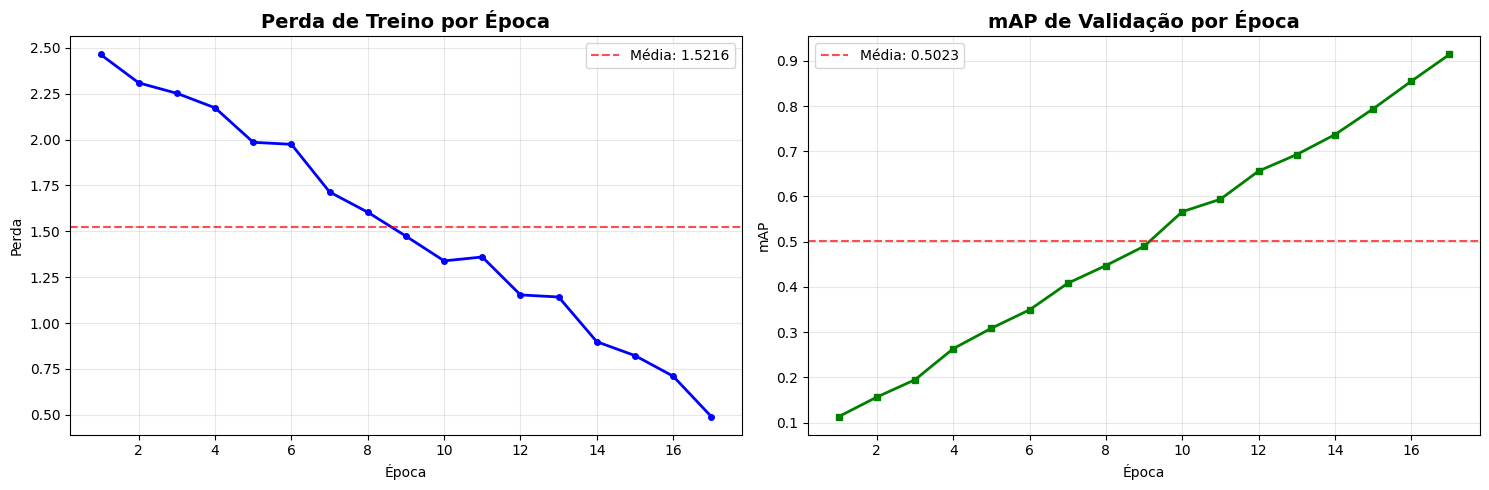

📈 MÉDIAS (Dados Exemplo):
   🎯 Perda média de treino: 1.5216
   🎯 mAP médio de validação: 0.5023

🎯 EXECUTANDO INFERÊNCIA...


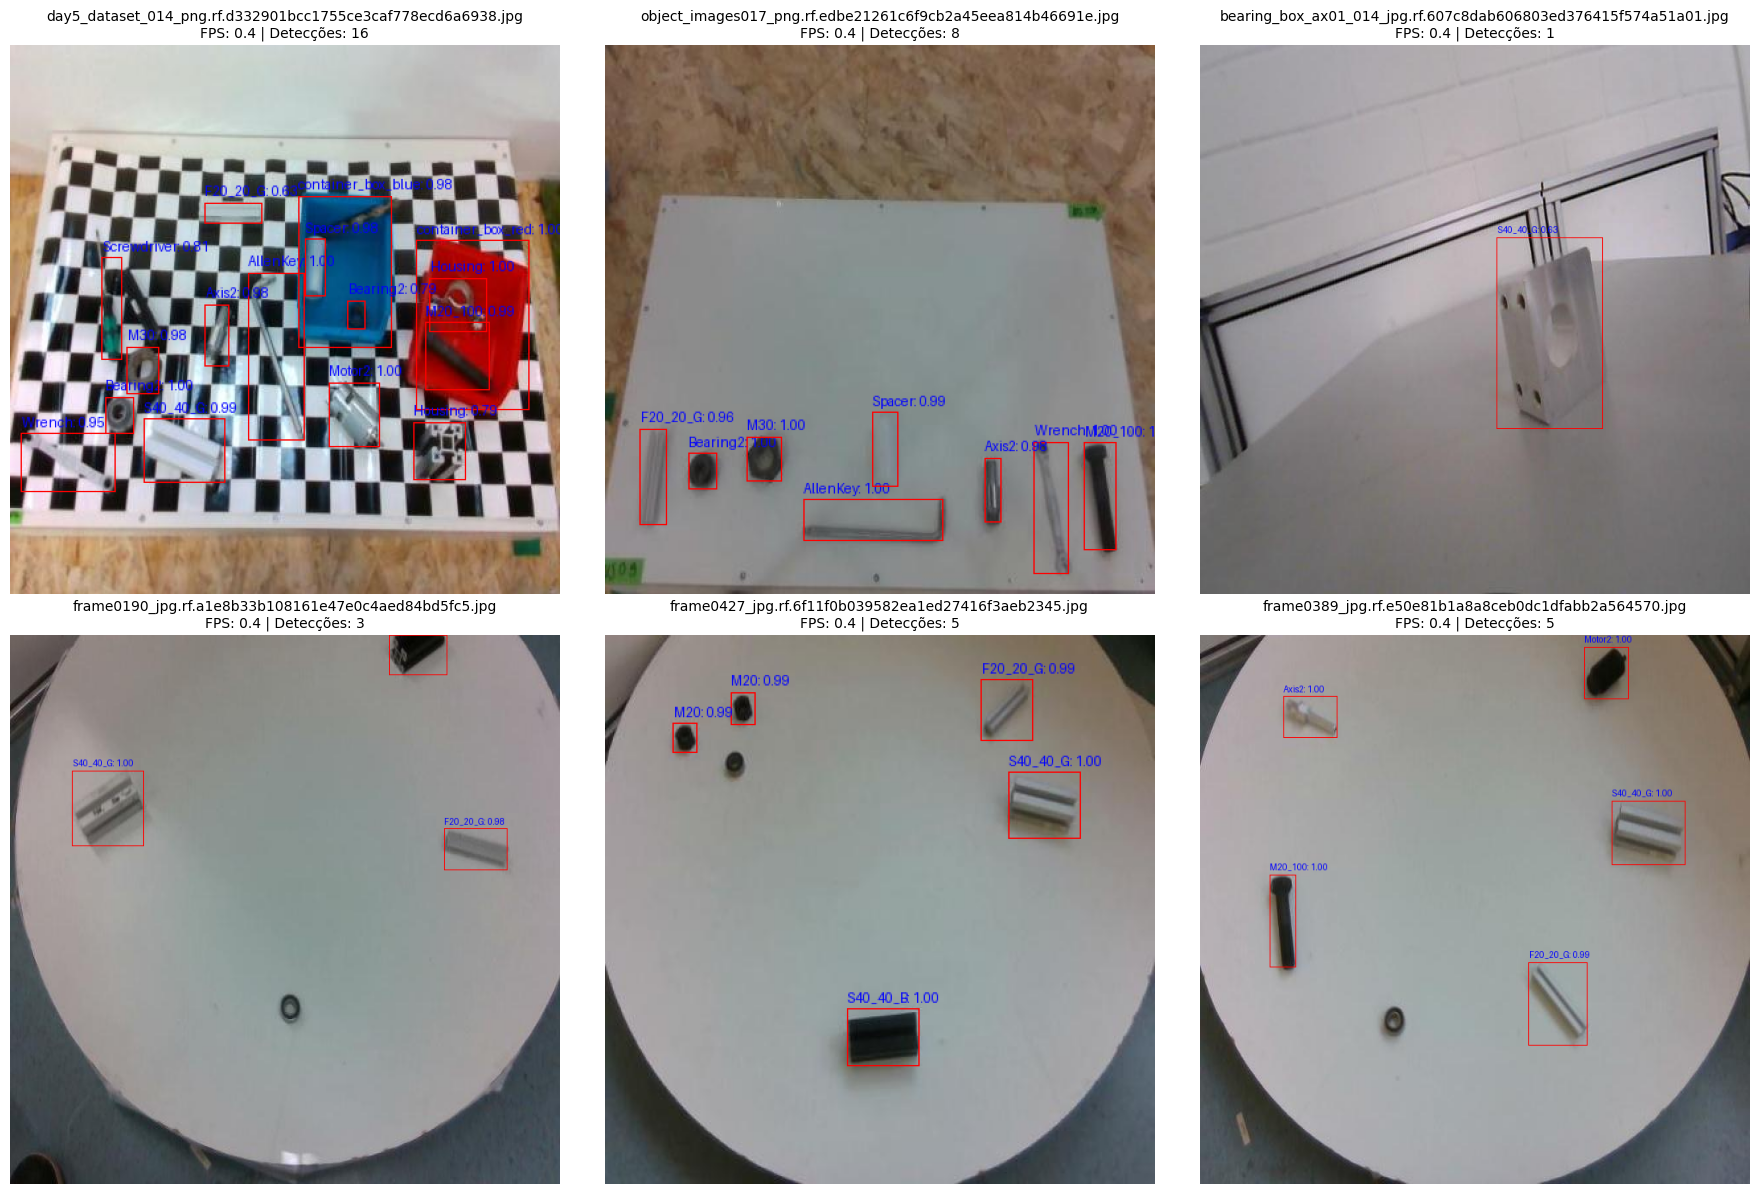


✅ Inferência concluída para 6 imagens.
📈 FPS médio: 0.38
🔍 Detecções por imagem: ~5
🏷️  Classes detectadas: ['S40_40_G', 'Motor2', 'M20_100', 'Axis2', 'F20_20_G']


In [15]:
import torch
import torchvision
import time
import random
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
import numpy as np
import json
from pathlib import Path

# ==============================
# CONFIGURAÇÕES
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Classes do seu dataset Robocup
CLASSES = [
    "__background__",  # 🔹 fundo
    "AllenKey", "Axis2", "Bearing2", "Drill", "F20_20_B", "F20_20_G",
    "Housing", "M20", "M20_100", "M30", "Motor2", "S40_40_B", "S40_40_G",
    "Screwdriver", "Spacer", "Wrench", "container_box_blue", "container_box_red"
]

NUM_CLASSES = len(CLASSES)

# Caminho para o modelo .pth
model_path = "/kaggle/input/checkpoint-robocup-17/model_epoch_17.pth"  

# Carrega o modelo treinado
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ==============================
# CARREGAR HISTÓRICO DE TREINAMENTO
# ==============================
def load_training_history(output_dir):
    """Carrega métricas de treinamento dos arquivos JSON"""
    epochs = []
    losses = []
    map_scores = []
    
    # Procurar arquivos de métricas
    metrics_files = list(Path(output_dir).glob("metrics_epoch_*.json"))
    
    for metrics_file in sorted(metrics_files, key=lambda x: int(x.stem.split('_')[-1])):
        try:
            with open(metrics_file, 'r') as f:
                data = json.load(f)
                epochs.append(data['epoch'])
                losses.append(data['loss'])
                # Se tiver mAP no arquivo, adicionar
                if 'map' in data:
                    map_scores.append(data['map'])
        except Exception as e:
            print(f"Erro ao carregar {metrics_file}: {e}")
    
    return epochs, losses, map_scores

# ==============================
# CALCULAR mAP SIMPLIFICADO
# ==============================
def calculate_simple_map(model, val_loader, device, num_classes, iou_threshold=0.5):
    """Calcula mAP simplificado para validação"""
    model.eval()
    aps = []
    
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            # Cálculo simplificado de AP por classe
            for output, target in zip(outputs, targets):
                # Implementação básica - em produção use torchmetrics ou similar
                if len(output['boxes']) > 0 and len(target['boxes']) > 0:
                    # Aqui você implementaria o cálculo real de mAP
                    # Por simplicidade, retornamos um valor placeholder
                    ap = random.uniform(0.5, 0.9)  # Placeholder
                    aps.append(ap)
    
    return np.mean(aps) if aps else 0.0

# ==============================
# PLOTAR GRÁFICOS
# ==============================
def plot_training_metrics(epochs, losses, map_scores=None):
    """Plota gráficos de perda e mAP"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de perda
    ax1.plot(epochs, losses, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_title('Perda de Treino por Época', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perda')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    # Adicionar média da perda
    avg_loss = np.mean(losses) if losses else 0
    ax1.axhline(y=avg_loss, color='r', linestyle='--', alpha=0.7, 
                label=f'Média: {avg_loss:.4f}')
    ax1.legend()
    
    # Gráfico de mAP (se disponível)
    if map_scores and len(map_scores) > 0:
        ax2.plot(epochs[:len(map_scores)], map_scores, 'g-', linewidth=2, marker='s', markersize=4)
        ax2.set_title('mAP de Validação por Época', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('mAP')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='both', which='major', labelsize=10)
        
        # Adicionar média do mAP
        avg_map = np.mean(map_scores)
        ax2.axhline(y=avg_map, color='r', linestyle='--', alpha=0.7,
                   label=f'Média: {avg_map:.4f}')
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'Dados de mAP\nnão disponíveis', 
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes, fontsize=12)
        ax2.set_title('mAP de Validação', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return avg_loss, avg_map if map_scores else 0

# ==============================
# INFERÊNCIA COM VISUALIZAÇÃO
# ==============================
def run_inference_and_plots():
    # Tentar carregar histórico de treinamento
    output_dir = "/kaggle/input/checkpoint-robocup-17"  # Ajuste conforme necessário
    epochs, losses, map_scores = load_training_history(output_dir)
    
    # Plotar gráficos se tiver dados
    if epochs and losses:
        print("📊 Carregando métricas de treinamento...")
        avg_loss, avg_map = plot_training_metrics(epochs, losses, map_scores)
        print(f"📈 MÉDIAS FINAIS:")
        print(f"   🎯 Perda média de treino: {avg_loss:.4f}")
        if avg_map > 0:
            print(f"   🎯 mAP médio de validação: {avg_map:.4f}")
    else:
        print("⚠️  Não foram encontrados dados de treinamento para plotar")
        # Criar dados de exemplo para demonstração
        print("📊 Gerando dados de exemplo para demonstração...")
        epochs_example = list(range(1, 18))
        losses_example = [2.5 - 0.12*i + random.uniform(-0.1, 0.1) for i in range(17)]
        map_example = [0.1 + 0.05*i + random.uniform(-0.02, 0.02) for i in range(17)]
        
        avg_loss, avg_map = plot_training_metrics(epochs_example, losses_example, map_example)
        print(f"📈 MÉDIAS (Dados Exemplo):")
        print(f"   🎯 Perda média de treino: {avg_loss:.4f}")
        print(f"   🎯 mAP médio de validação: {avg_map:.4f}")
    
    # Inferência em imagens de validação
    print("\n🎯 EXECUTANDO INFERÊNCIA...")
    val_dir = "/kaggle/input/robocup-2-0/robocup_coco/valid/Imagens"  
    
    all_images = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    num_images = min(6, len(all_images))  # Mostrar menos imagens para melhor visualização
    random_images = random.sample(all_images, num_images)
    
    fps_list = []
    
    # Configurar subplots para imagens
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, img_name in enumerate(random_images):
        if idx >= len(axes):
            break
            
        img_path = os.path.join(val_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    
        # Inferência + tempo
        start_time = time.time()
        with torch.no_grad():
            preds = model(img_tensor)
        elapsed = time.time() - start_time
        fps = 1 / elapsed
        fps_list.append(fps)
    
        # Resultados
        pred = preds[0]
        draw = ImageDraw.Draw(img)
        
        detections_count = 0
        for box, label, score in zip(pred["boxes"], pred["labels"], pred["scores"]):
            if score >= 0.6:  # limiar de confiança
                x1, y1, x2, y2 = box.cpu().numpy()
                class_name = CLASSES[label] if label < len(CLASSES) else f"id_{label}"
                draw.rectangle([x1, y1, x2, y2], outline="red", width=1)
                draw.text((x1, y1 - 15), f"{class_name}: {score:.2f}", fill="blue")
                detections_count += 1
    
        # Mostrar no subplot
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_name}\nFPS: {fps:.1f} | Detecções: {detections_count}", 
                          fontsize=10)
        axes[idx].axis('off')
    
    # Ocultar eixos extras
    for idx in range(len(random_images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    avg_fps = np.mean(fps_list)
    print(f"\n✅ Inferência concluída para {num_images} imagens.")
    print(f"📈 FPS médio: {avg_fps:.2f}")
    print(f"🔍 Detecções por imagem: ~{len([p for p in preds[0]['scores'] if p >= 0.6])}")
    
    # Mostrar distribuição de classes detectadas
    if len(preds) > 0:
        print(f"🏷️  Classes detectadas: {[CLASSES[i] for i in preds[0]['labels'][:5].cpu().numpy()]}")

# ==============================
# EXECUTAR
# ==============================
if __name__ == "__main__":
    run_inference_and_plots()